In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import os



from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46459 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46459/status,
Dashboard: /proxy/46459/status,Workers: 6
Total threads: 24,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46513,Workers: 6
Dashboard: /proxy/46459/status,Total threads: 24
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:34421,Total threads: 4
Dashboard: /proxy/34907/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36357,


In [2]:
surface = xr.open_dataset("/g/data/nm03/ab8992/fullexpt-test/output004/surface.nc",decode_times = False)
dKE_dt = xr.open_dataset("/g/data/nm03/ab8992/fullexpt-test/output004/dKE_dt.nc",decode_times = False).dKE_dt
KE_horvisc = xr.open_dataset("/g/data/nm03/ab8992/fullexpt-test/output004/KE_horvisc.nc",decode_times = False).KE_horvisc
KE_visc = xr.open_dataset("/g/data/nm03/ab8992/fullexpt-test/output004/KE_visc.nc",decode_times = False).KE_visc
KE_stress = xr.open_dataset("/g/data/nm03/ab8992/fullexpt-test/output004/KE_stress.nc",decode_times = False).KE_stress
PE_to_KE = xr.open_dataset("/g/data/nm03/ab8992/fullexpt-test/output004/PE_to_KE.nc",decode_times = False).PE_to_KE
u = xr.open_mfdataset("/g/data/nm03/ab8992/fullexpt-test/output004/u/*",decode_times = False).u
v = xr.open_mfdataset("/g/data/nm03/ab8992/fullexpt-test/output004/v/*",decode_times = False).v
h = xr.open_mfdataset("/g/data/nm03/ab8992/fullexpt-test/output004/h/*",decode_times = False).h
# e = xr.open_mfdataset("/g/data/nm03/ab8992/fullexpt-test/output004/e/*",decode_times = False).e
rho = xr.open_mfdataset("/g/data/nm03/ab8992/fullexpt-test/output004/rho/*",decode_times = False).rhopot2
depth = h.cumsum("zl")

u_along = np.sqrt(u**2 + v**2)

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/nm03/ab8992/fullexpt-test/output004/surface.nc'

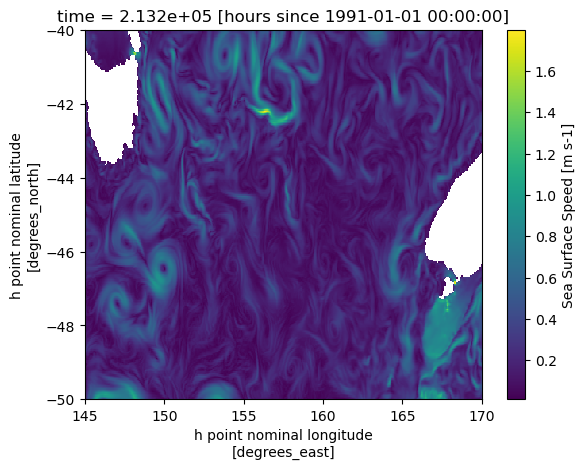

In [6]:
surface.speed.isel(time=0).sel(xh = slice(145,170),yh = slice(-50,-40)).plot()

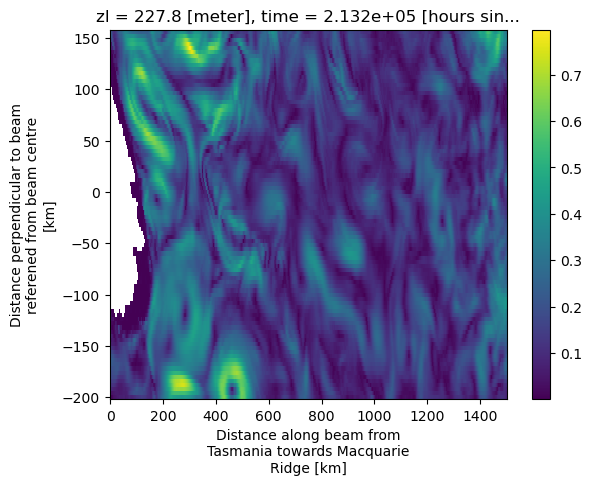

In [21]:
u_along.isel(time = 5,zl = 30).plot()

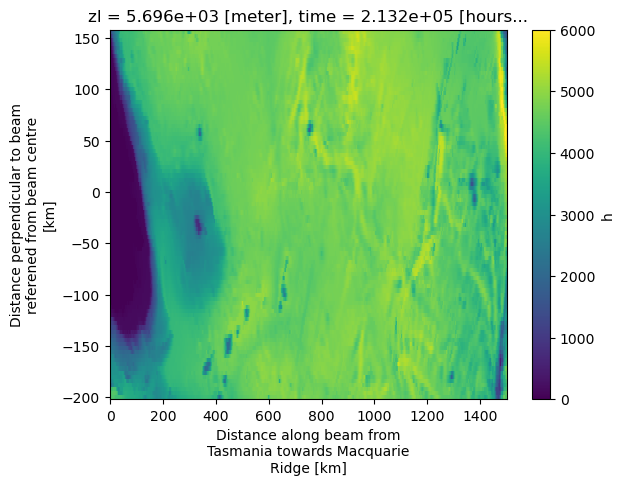

In [18]:
depth.isel(zl = -1,time = 0).plot()

Text(0.5, 1.0, 'PE_to_KE')

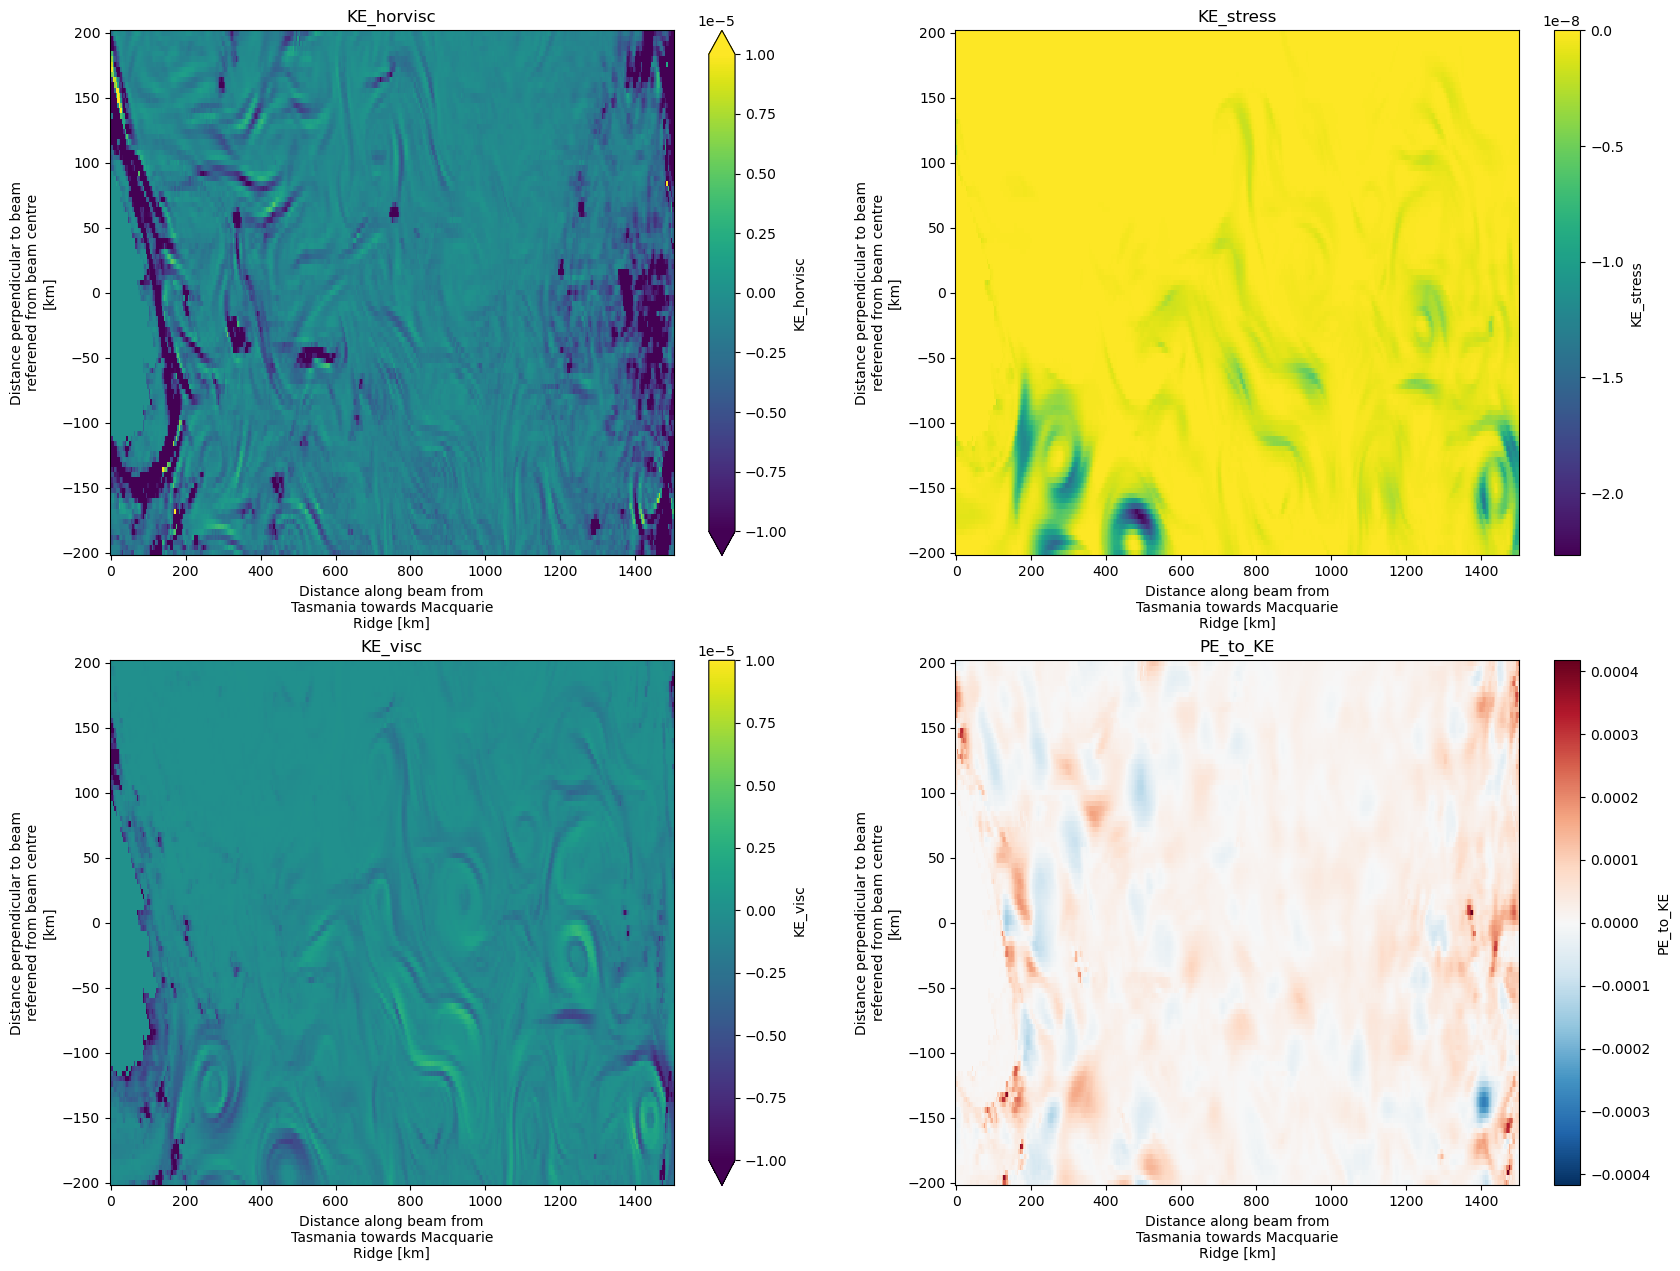

In [26]:
fig,ax = plt.subplots(2,2,figsize = (20,15))

KE_horvisc.mean("time").sum("rho2_l").plot(ax = ax[0,0],vmin = -0.00001,vmax = 0.00001)
ax[0,0].set_title("KE_horvisc")
KE_stress.mean("time").sum("rho2_l").plot(ax = ax[0,1])
ax[0,1].set_title("KE_stress")
KE_visc.mean("time").sum("rho2_l").plot(ax = ax[1,0],vmin = -0.00001,vmax = 0.00001)
ax[1,0].set_title("KE_visc")
PE_to_KE.mean("time").sum("rho2_l").plot(ax = ax[1,1])
ax[1,1].set_title("PE_to_KE")

/home/149/ab8992/.local/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


Text(0.5, 1.0, 'PE_to_KE')

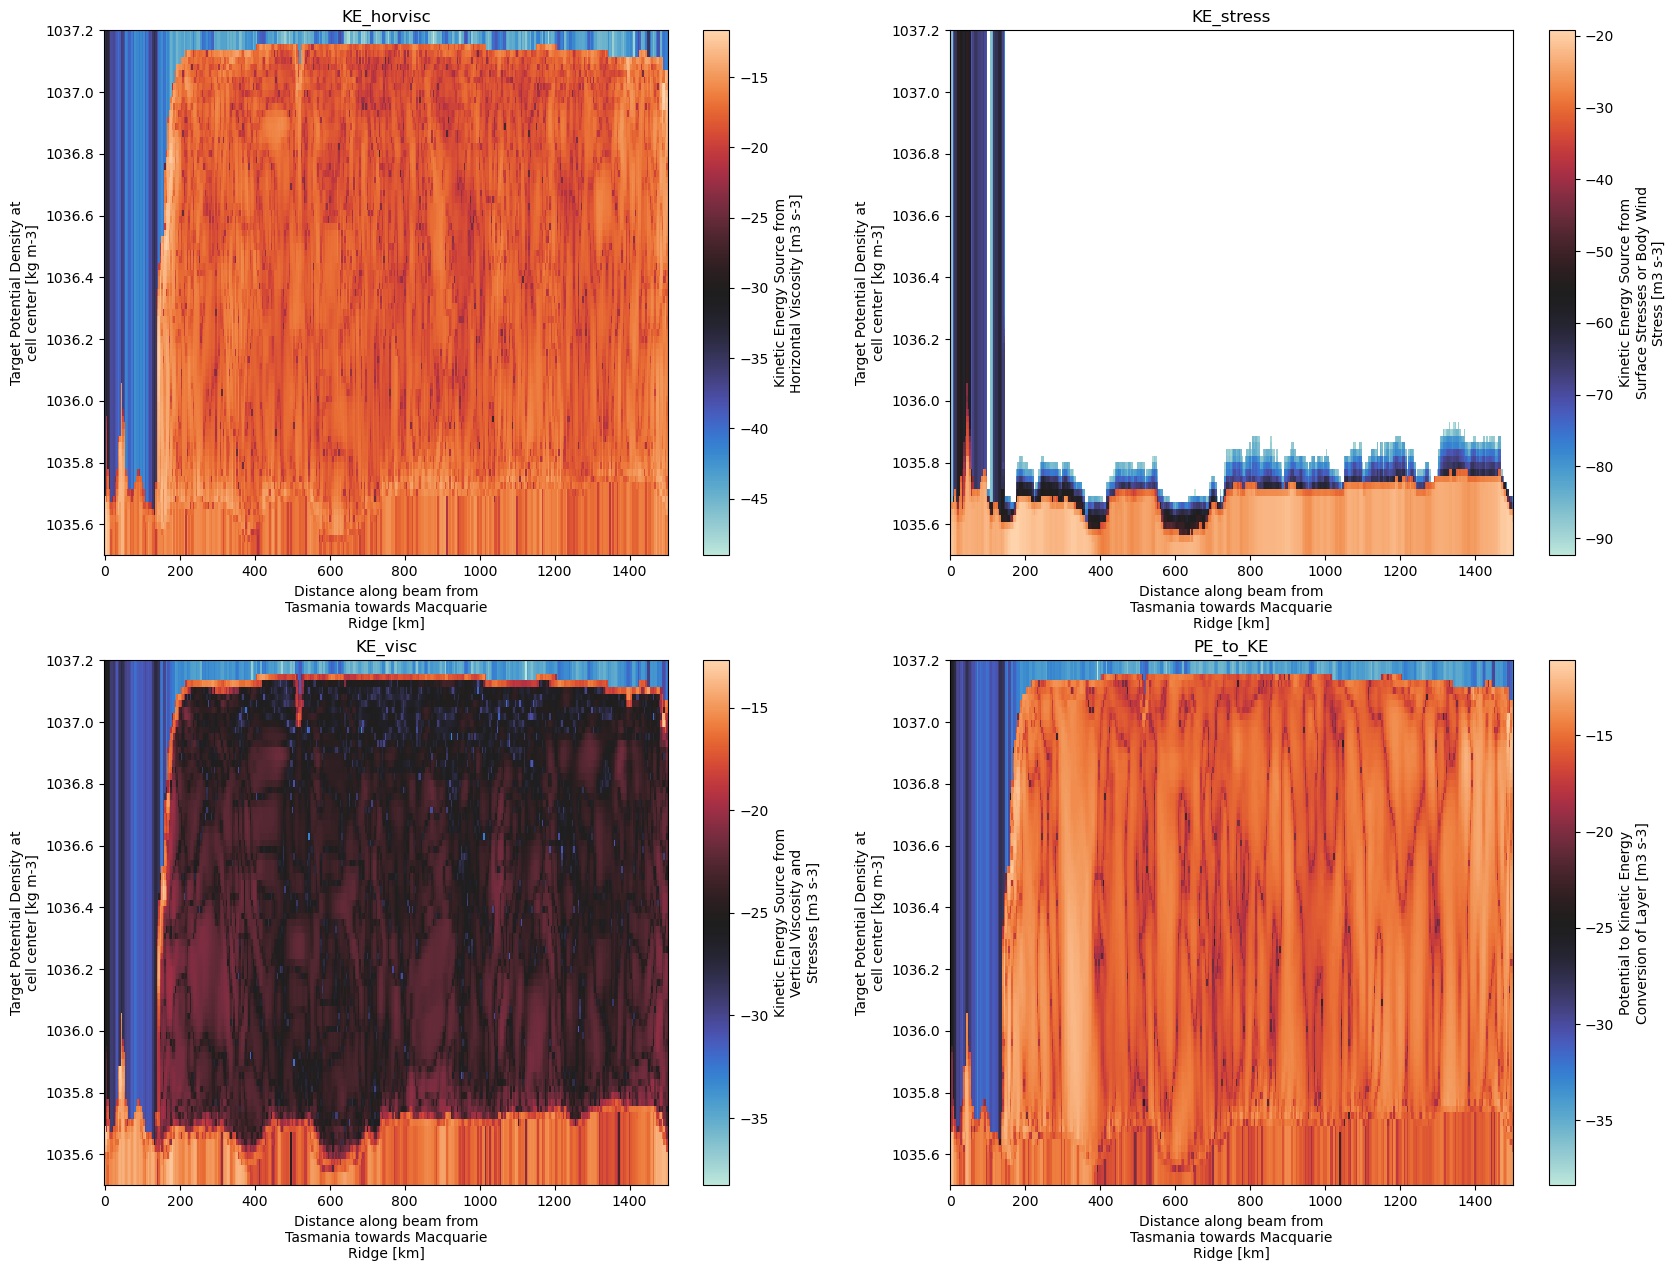

In [21]:
import seaborn as sns

depth = h.isel(yb = 20).cumsum("zl")

fig,ax = plt.subplots(2,2,figsize = (20,15))
cmap = sns.color_palette("icefire", as_cmap=True)
np.log(np.abs(KE_horvisc)).isel(time = 5,yb = 20).plot(ax = ax[0,0],cmap = cmap)
# ax.fill_between(datau.xb.values,depth[5,-1,:],5500,color = "gray")

ax[0,0].set_title("KE_horvisc")

np.log(np.abs(KE_stress)).isel(time = 5,yb = 20).plot(ax = ax[0,1],cmap = cmap)
ax[0,1].set_title("KE_stress")
np.log(np.abs(KE_visc)).isel(time = 5,yb = 20).plot(ax = ax[1,0],cmap = cmap)
ax[1,0].set_title("KE_visc")
np.log(np.abs(PE_to_KE)).isel(time = 5,yb = 20).plot(ax = ax[1,1],cmap = cmap)
ax[1,1].set_title("PE_to_KE")

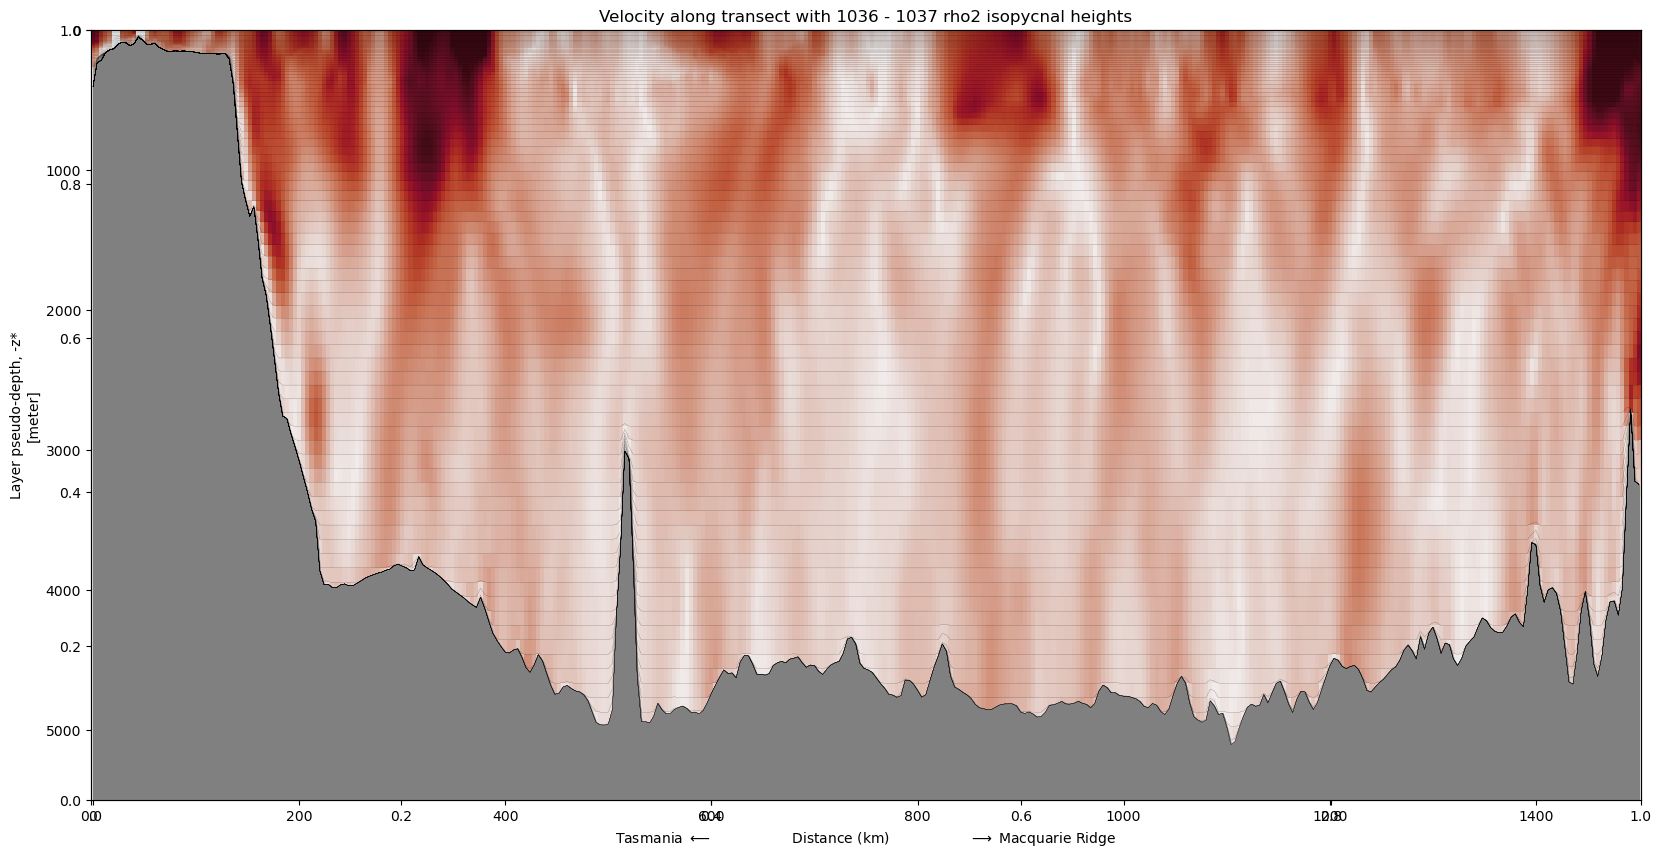

In [7]:
import cmocean.cm as cm                              # Nice colormaps

def plotvtransect(data,fig,tt,framedim = "time"):
    ax = fig.subplots(1)


    data.u.isel(time = tt).plot(vmin = -0.4,vmax = 0.4,cmap = cm.balance,ax = ax,y = "zl",add_colorbar = False)



    # for ii in range(20,80,10):
    #     ax.plot(data.u.xb.values,-1 * data.isop_transect[tt,ii,:],'green',linewidth=1)

    for ii in range(data.h.shape[1] - 1):
        ax.plot(data.u.xb.values,data.depth[tt,ii,:],'black',linewidth=0.1)

    ax.fill_between(data.u.xb.values,data.depth[tt,-1,:],5500,color = "gray")
    ax.set_ylim(0,5500)
    ax.invert_yaxis()
    ax.set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
    ax.set_title("Velocity along transect with 1036 - 1037 rho2 isopycnal heights")
    return 

data = xr.Dataset(
    {"u":u_along.isel(yb = 20),
     "depth":h.isel(yb = 20).cumsum("zl"),
     "h":h.isel(yb = 20)}
)
fig,ax = plt.subplots(1,1,figsize = (20,10))
plotvtransect(data,fig,1)

In [14]:
e = xr.open_mfdataset("/home/149/ab8992/tasman-tides/rundirs/fullexpt-test/archive/output004/*e.nc",decode_times = False).e


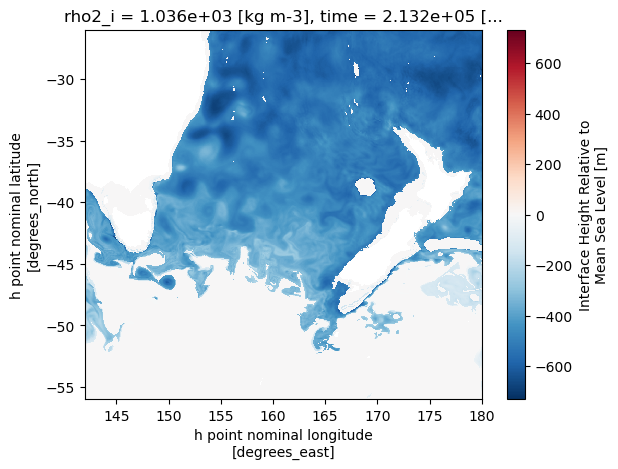

In [18]:
e.isel(time = 0,rho2_i = 5).plot()

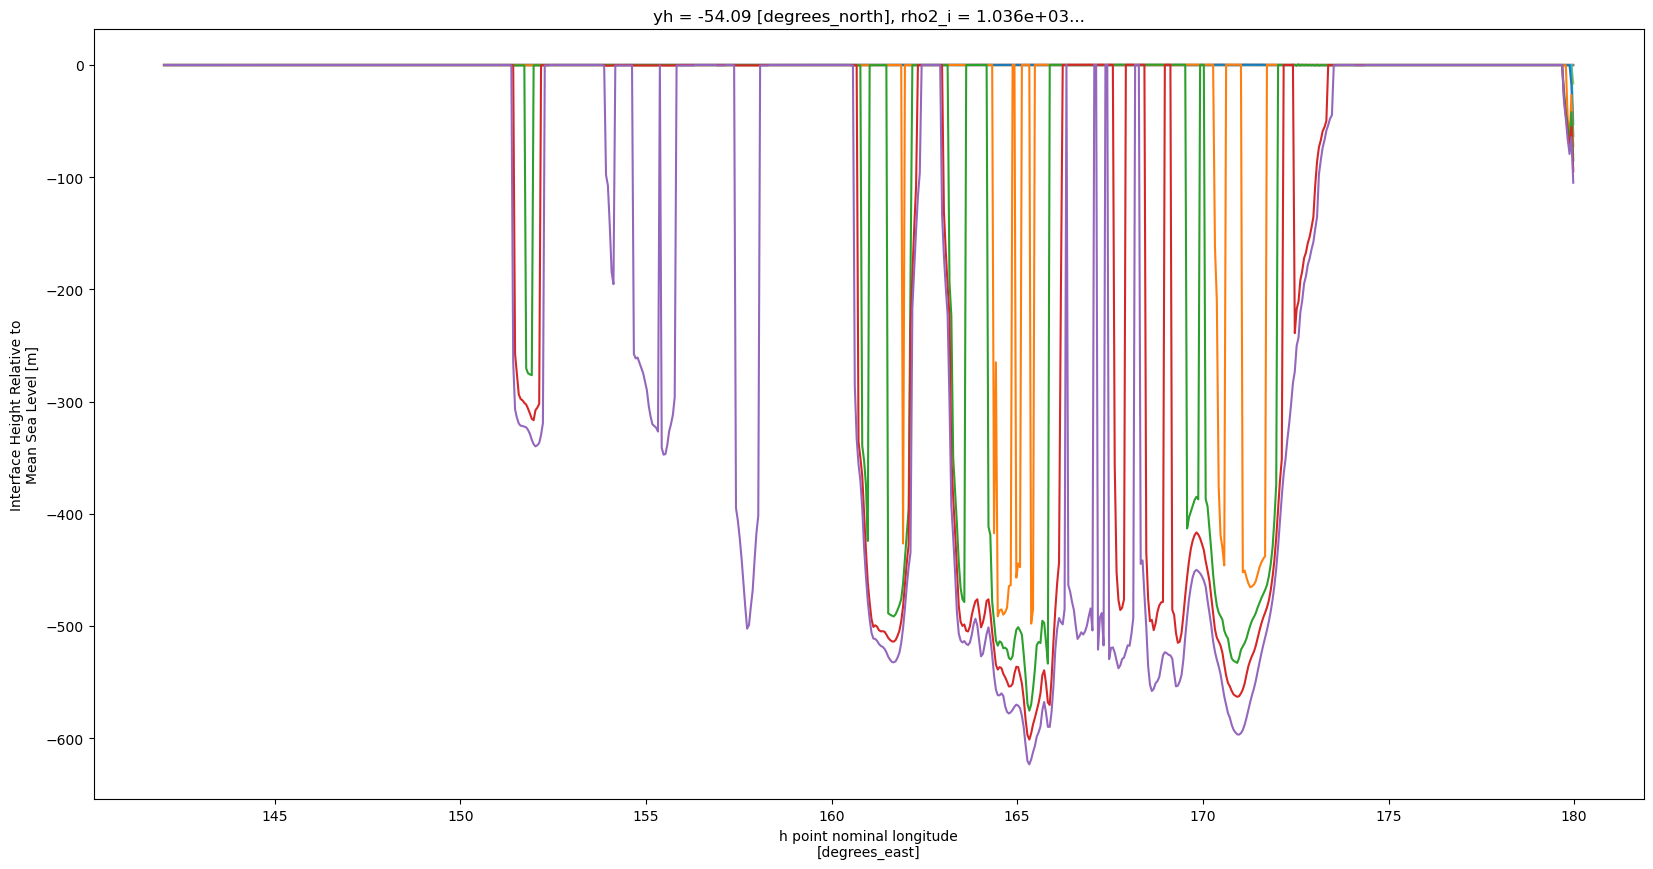

In [13]:
fig,axis = plt.subplots(1,1,figsize = (20,10))
for i in range(15):
    e.isel(rho2_i = i).plot(ax = axis)

In [32]:
import math

a = 100
b = 1242

print(16 * 24 / 12.5)


30.72


In [20]:
math.gcd(a, b)

2